In [8]:
# Import helpful libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Set up filepaths
data_url = 'https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club_reduced.csv'

X_full = pd.read_csv(data_url,index_col='Id')

X_full.head()

,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,
1,0,10,MORTGAGE,50000.0,not verified,n,medical,766xx,TX,10.87,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
2,0,1,RENT,39216.0,not verified,n,debt consolidation,660xx,KS,9.15,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
3,0,4,RENT,65000.0,not verified,n,credit card,916xx,CA,11.24,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
4,0,10,MORTGAGE,57500.0,not verified,n,debt consolidation,124xx,NY,6.18,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
5,0,10,MORTGAGE,50004.0,VERIFIED - income,n,debt consolidation,439xx,OH,19.03,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


### Review dataset shape and null values

In [9]:
# Lay out shape of the dataset, review null data points
print(X_full.shape)
missing_vals = X_full.isnull().sum()
print(missing_vals[missing_vals > 0])

(10000, 23)
annual_inc                       1
delinq_2yrs                      5
inq_last_6mths                   5
mths_since_last_delinq        6316
mths_since_last_record        9160
open_acc                         5
pub_rec                          5
revol_util                      26
total_acc                        5
collections_12_mths_ex_med      32
dtype: int64


### Target

Target is 'is_bad' is imbalanced towards 0, with only 13% 1s in the dataset.

0    8705
1    1295
Name: is_bad, dtype: int64

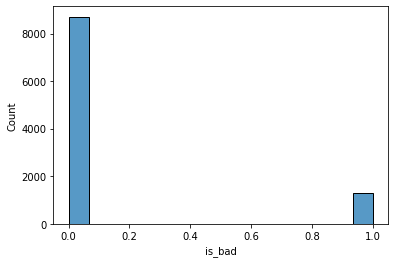

In [37]:
sns.histplot(data=X_full,x='is_bad')

X_full['is_bad'].value_counts()

First I'll look for ways I can reduce or simplify the data. Reviewing the missing values, 'mths_since_last_delinq' and 'mths_since_last_record' have greater than 50% missing values due to the nature of datapoint (months since event that may have never happened), I'm wondering if these can't be simplified to a boolean value if we can see an even correlation between any delinqunecy at all or any record at all on the target.


### Review of number of months since the loan applicant last missed a loan repayment variable

<AxesSubplot:xlabel='mths_since_last_delinq', ylabel='Count'>

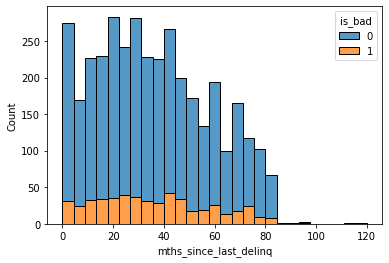

In [10]:
sns.histplot(data=X_full, x="mths_since_last_delinq", hue="is_bad",multiple="stack")

Breaking down the above plot for months since last delinquency, we see a fairly even trend across the board for the number of 'is_bad' cases with months since last delinquency out to 80 monts. The magnitude of is_bad occurances out past 80 months is effectively 0. You do see a trend showing that longer time since last delinquency results in a slightly smaller count of 'is_bad', however, it not a clear linear relationship with lenght of time since last delinquency. This behavior is in line with what I would expect. It may be appropriate to treat this column as a boolean showing past deliquency 1 or 0 to simplify.

I'd like to see how this compares to the null data which won't be shown, I'm going to create a copy and replace all null values with something outside of the dataset measurement range (200 months). The implication here would be a value of 200 months mean the individual has had no past deliquency.

<AxesSubplot:xlabel='mths_since_last_delinq', ylabel='Count'>

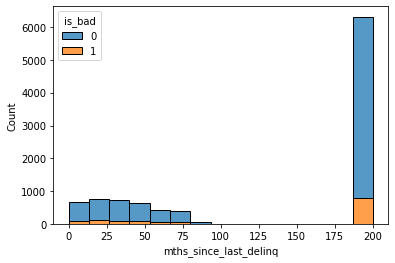

In [11]:
X_copy = X_full.copy()
X_copy['mths_since_last_delinq'].fillna(200,inplace=True)
sns.histplot(data=X_copy, x='mths_since_last_delinq',hue='is_bad',multiple="stack")


This plots shows that the number of 2nd or more time deliqunecy pales in comparison to first time delinquency. This tells me that the variable 'mths_since_last_delinq' may not be a strong indicator for a positive 'is_bad'.

### Review of number of months since the loan applicant’s last public record court judgement variable

<AxesSubplot:xlabel='mths_since_last_record', ylabel='Count'>

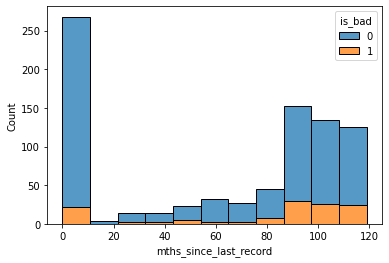

In [12]:
sns.histplot(data=X_full, x="mths_since_last_record",hue="is_bad", multiple="stack")

<AxesSubplot:xlabel='mths_since_last_record', ylabel='Count'>

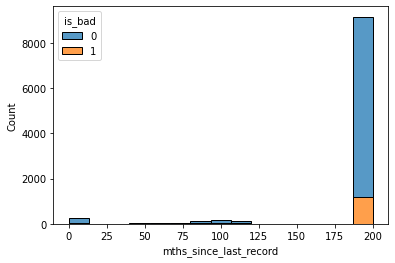

In [13]:
# I'm going to create a copy and replace all null values with something outside of the dataset measurement range (200 months). 
X_copy = X_full.copy()
X_copy['mths_since_last_record'].fillna(200,inplace=True)
sns.histplot(data=X_copy, x='mths_since_last_record',hue='is_bad',multiple="stack")

The story for 'mths_since_last_record' is not quite as straightforward. I'm seeing a trend somewhat counter to what I'd expect if this variable were strongly correlated to a positive 'is_bad', where the magnitude of is_bad count is much higher for long periods of time since last court judgement, even than 0-10 months previous. This is pretty intresting, and I'm struggling to come up with an explanation as to why this data presents this way. The magnitudes here for a 10,000 sample set are quite low, so it's potentially just an artifact of sampling. I don't have access to the exact years, but I'm wondering if this couldn't be something like the 2008 financial crisis impacting individuals again in the 2018 recession based on the time difference. Once again we're seeing the magnitidue of deliquency for individuals with no past judgements is much higher, so probaby a poor predictor of delinquency.

### Full dataset visualizations

Before I take a look at the full dataset, I'm going to note my thoughts for what I expect to be the strongest predictors for the target. This exercise will help me identify things I need to take a closer look at for cleaning, and highlight things I may need to understand better about the data before applying to model.

My expecation is the following will be the strongest predictors: 

debt_to_income, collections_12_mnths_ex_med, delinq_2yrs, revol_util, annual_inc,
mnths_since_last_major_derog, pymnt_plan

<AxesSubplot:>

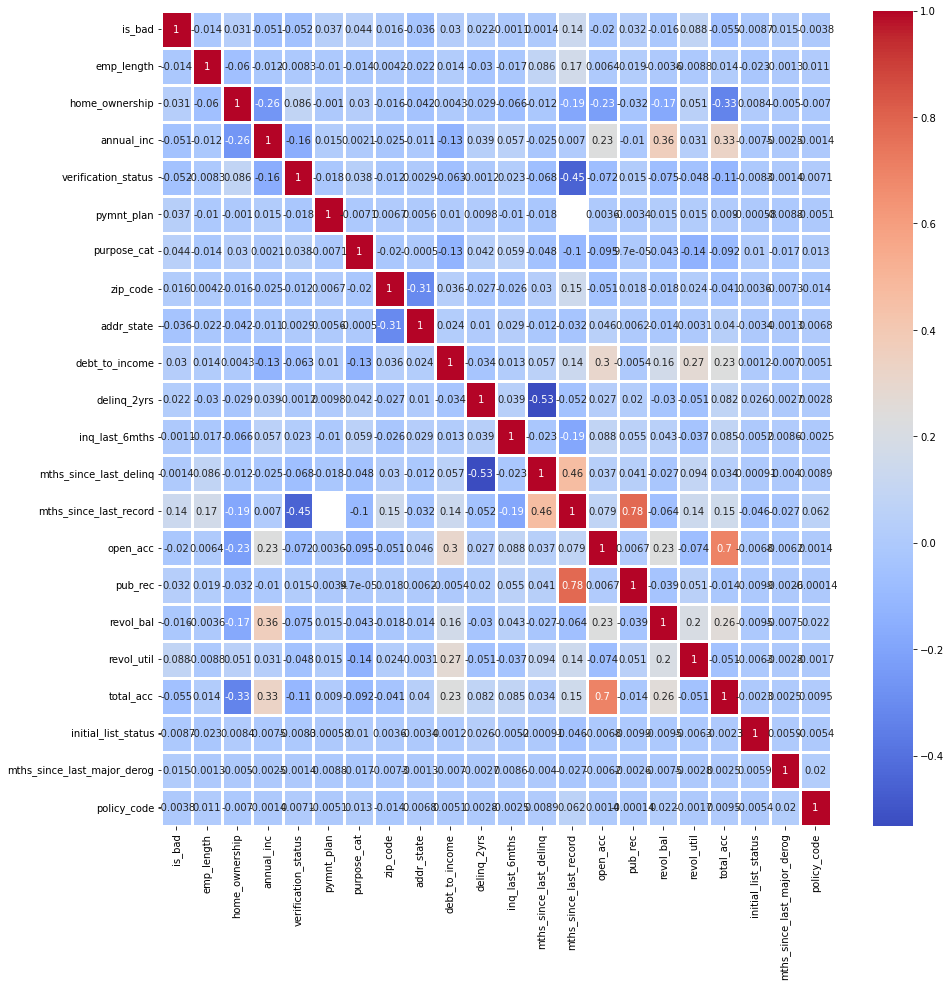

In [14]:
X_copy_encoded = X_full.copy()
X_copy_encoded.drop(columns=['collections_12_mths_ex_med'],inplace=True)

label_encode = preprocessing.LabelEncoder()

# Loop across each column in the dataset
for col in X_copy_encoded.columns:
    # Check that column data is not int64 or float64, not necessary to encode
    if X_copy_encoded.dtypes[col] != 'int64' and X_copy_encoded.dtypes[col] != 'float64':
        # Encode all categorical data for use in model
        X_copy_encoded[col] = label_encode.fit_transform(X_copy_encoded[col])
        
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X_copy_encoded.corr(), annot=True, cmap='coolwarm', linewidth=3.0)


Observations of heatmap data correlations is_bad relations
- annual_inc has one of the stronger negative correlations (lower income higher chance of default), as expected
- debt_to_income has one of the higher positive correlations, as expected
- mths_since_last_record erroneously has the highest correlation, this is an artifact of > 90% of the data in this column is null 
- open_acc shows a stronger negatvie correlation, typically an individual with good history will be approved for more accounts.
- pub_rec has a fairly strong positive correlation which is logical
- revol_bal shows a negative correlation, which I would not expect. This warrants a closer look.
- revol_util has a high corr to is_bad, this is exepcted as one of the key parameters for your credit score is a low % utilization
- total_acc has a strong negative correlation, typically an individual with good history will be approved for more accounts.
- mths_since_last_major_derog showing a fairly strong positive correlation, which I can't make sense out of. Needs a closer look.
Observations of heatmap for column-to-column correlation
- delinq_2yrs is very strongly corr to mths_since_last_delinq. This is expected, and in this scenario makes sense to drop mths_since_last_delinq from dataset in favor of delinq_2yrs. delinq_2yrs has a higher corr to is_bad, and is a far more complete dataset.
- pub_rec and mths_since_last_record > 0.7 corr, logical to remove mths_since_last_record for same reason as previous bullet.
- open_acc and total_acc have ~0.7 corr, logical to remove open_acc since both are negatively corr to is_bad, but total_acc is stronger corr

### Open Accounts variable

Looking closer at open_acc, we see that the risk of default goes down with a greater number of open accounts. This is logical, as typically only someone with a strong credit history will be approved for more accounts.

<AxesSubplot:xlabel='open_acc', ylabel='Count'>

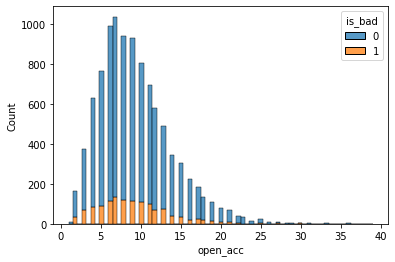

In [15]:
sns.histplot(data=X_full, x="open_acc", hue="is_bad",multiple="stack")

### Revolving credit balance variable

Looking closer at the revolving credit balance, upon first look I didn't expect a negative correlation here. What's clear in the data, however, is that the large majority of defaults happen with revolving balances < $20,000. I believe what we're seeing here is individuals with these much higher balances likely have large mortages or large student loans which are going to be associated to a higher income. One thing to note when looking at a plot like this, you have a much higher number of samples down below 20,000, so to get a better understanding you would want to look at the % of is_bad = 1 when counting the total 0 + 1 bin.

(-5000.0, 100000.0)

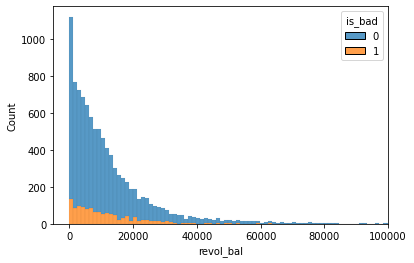

In [16]:
fig, ax = plt.subplots()
sns.histplot(data=X_full, x="revol_bal", hue="is_bad",multiple="stack")
ax.set_xlim(-5000,100000)


### Months since last major derogatory mark variable

It seems as though theres either an error in the data, or this was supposed to be a categorical type data, but I'm missing information. I will remove this column from the model.


<AxesSubplot:xlabel='mths_since_last_major_derog', ylabel='Count'>

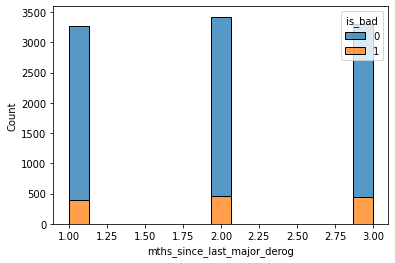

In [17]:

sns.histplot(data=X_full, x="mths_since_last_major_derog", hue="is_bad", multiple="stack")


### Categorical Data

Now to review categorical data that was not covered in the numerical correlation analysis. 

Columns: addr_state, home_ownership, initial_list_status, zip_code, pymnt_plan, policy_code, verification_status, purpose_cat

It appears as though some geographies are presenting a far higher number of samples, fairly concentrated.


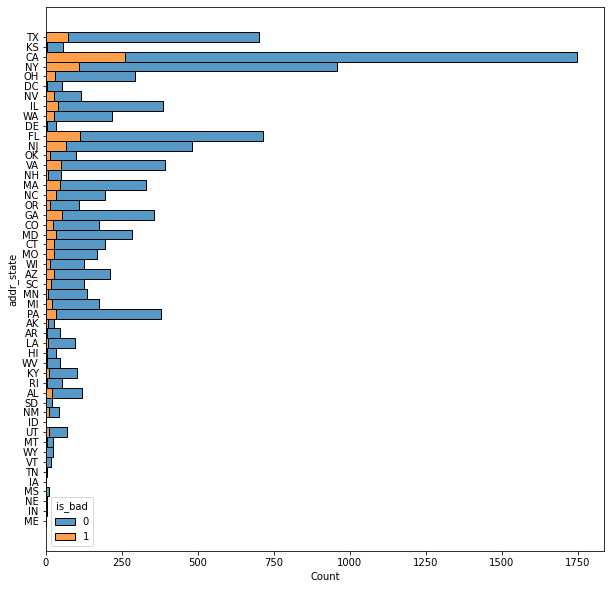

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.histplot(data=X_full, y="addr_state",hue="is_bad", multiple="stack",stat="count")

print("It appears as though some geographies are presenting a far higher number of samples, fairly concentrated.")

Mortgage and rent are showing a similiar default rate, while owning presents a much smaller subset of the data.


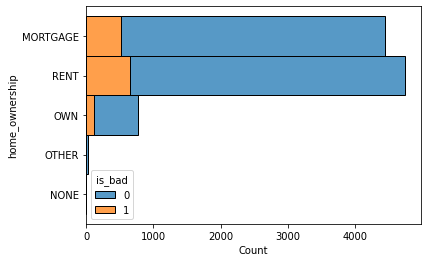

In [19]:
sns.histplot(data=X_full, y="home_ownership", hue="is_bad",multiple="stack",stat="count")

print("Mortgage and rent are showing a similiar default rate, while owning presents a much smaller subset of the data.")

It appears that the entire dataset is 'f', and therefore will not be useful for the model.


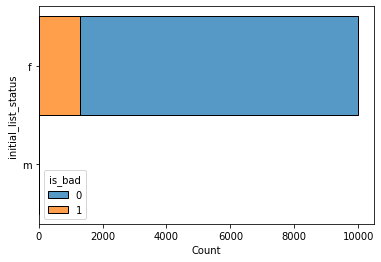

In [20]:
sns.histplot(data=X_full, y="initial_list_status", hue="is_bad",multiple="stack",stat="count")

print("It appears that the entire dataset is 'f', and therefore will not be useful for the model.")

Similar to the state representation, we're seeing a fairly concentrated geographic space represented.
This data also seems redundant to the State value. States give more meaningful magnitudes in the dataset.


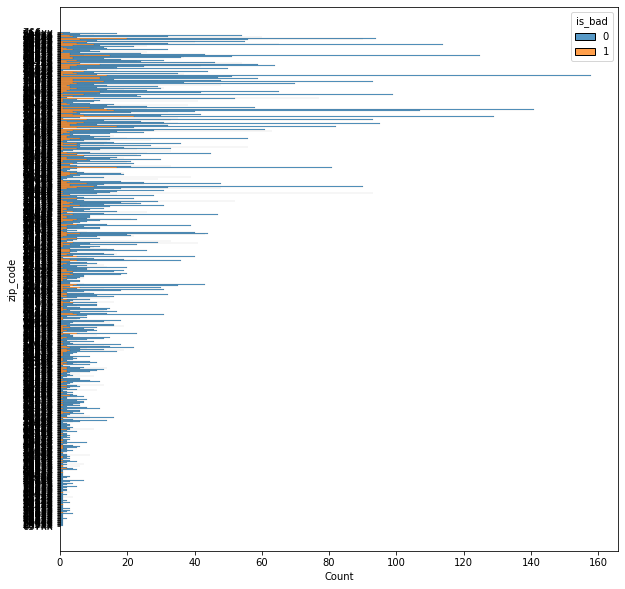

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.histplot(data=X_full, y="zip_code", hue="is_bad",multiple="stack",stat="count")

print("Similar to the state representation, we're seeing a fairly concentrated geographic space represented.")
print("This data also seems redundant to the State value. States give more meaningful magnitudes in the dataset.")

There are only 2 samples of 10,000 for 'y', so this will likely not be useful for the model either.


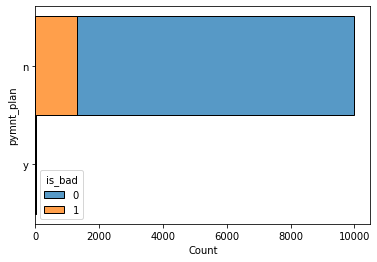

In [22]:
sns.histplot(data=X_full, y="pymnt_plan", hue="is_bad",multiple="stack",stat="count")

print("There are only 2 samples of 10,000 for 'y', so this will likely not be useful for the model either.")

In [23]:
X_full['pymnt_plan'].value_counts()

n    9998
y       2
Name: pymnt_plan, dtype: int64

Even distrubtion of the sample set, data appears complete.


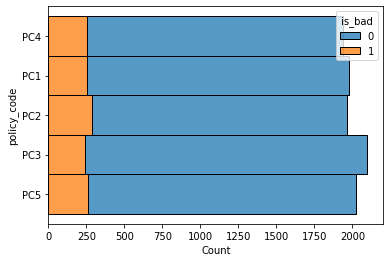

In [24]:
sns.histplot(data=X_full, y="policy_code", hue="is_bad",multiple="stack",stat="count")

print("Even distrubtion of the sample set, data appears complete.")

I'm surprised that not verified would have a lower default rate, but the data appears complete.


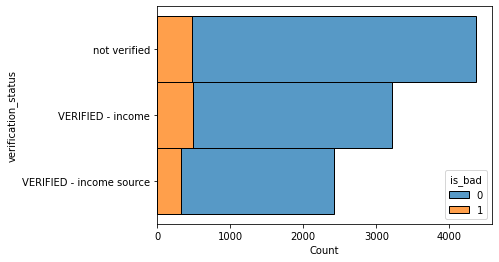

In [25]:
sns.histplot(data=X_full, y="verification_status", hue="is_bad",multiple="stack",stat="count")

print("I'm surprised that not verified would have a lower default rate, but the data appears complete.")

The data is heavily concentrated here to a handful of categories.


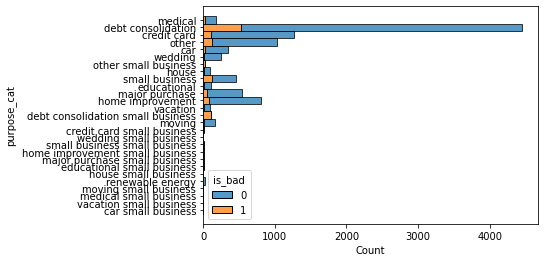

In [26]:
sns.histplot(data=X_full, y="purpose_cat", hue="is_bad",multiple="stack",stat="count")

print("The data is heavily concentrated here to a handful of categories.")

### Key Takeaways

Actions taken away from data exploration
- remove following columns from model for similarity: mths_since_last_delinq, mths_since_last_record, open_acc
- remove following columns from model for errors or not useful data: mths_since_last_major_derog, initial_list_status, pymnt_plan, collections_12_mths_ex_med
- after removal of these columns, null data replacement of the remaining sets should be readily handled with a median of the column

Notes
- Appears as though the dataset is highly concentrated geographically, I might be concerned about the model applying a greater weight to geography than warranted. 
- Annual income has high correlation with many parameters measured, I expect that to be one of the most critical parameters.
- Revolving % utilization is another parameter with high correlation to the target, no surprise considering % utilization is one of the largest indicators for personal credit score. 